# UBDC CCTV API
## Author: Yue Li
### Date: 28/04/2024

In [ ]:
# install the packages if you don't have them.
# !pip install requests
# !pip install pandas
# !pip install geopandas
# !pip install matplotlib
# !pip install contextily
# !pip install watermark

In [1]:
import requests
import json
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from datetime import datetime, timedelta

In [2]:
%load_ext watermark

In [3]:
%watermark --python 

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0



In [4]:
%watermark --packages requests,json,pandas,geopandas,matplotlib,contextily

requests  : 2.31.0
json      : 2.0.9
pandas    : 2.0.3
geopandas : 0.14.0
matplotlib: 3.7.2
contextily: 1.5.0



## CCTV data

UBDC is using images from CCTV cameras located around Glasgow to fuel a ML model trained to extract various object from them. Results can be accessed through a web app that contains two API endpoints. One for the counts and another one listing the available locations.

More information about UBDC CCTV dataset can be found here: https://glasgow-cctv.ubdc.ac.uk/

Results: `https://glasgow-cctv.ubdc.ac.uk/api/yolo/records/`

Cameras: `https://glasgow-cctv.ubdc.ac.uk/api/general/cameras/`

Documentation/Overview: `https://glasgow-cctv.ubdc.ac.uk/api/docs`

In [5]:
def get_data(url):
    response = requests.get(url)
    data = response.json()
    return data

### 1. Location of cameras

#### 1.1 Query data from the API

In [6]:
url = 'https://glasgow-cctv.ubdc.ac.uk/api/general/cameras/'
cameras = get_data(url)

In [7]:
cameras[0]

{'id': 12,
 'groups': [{'id': 2, 'name': 'City Centre'}],
 'camera_id': 'a13',
 'label': 'Byres Rd @ Dowanside Street (North)',
 'longitude': -4.294624,
 'latitude': 55.874577,
 'is_complete': True}

#### 1.2 Convert dictionary into dataframe

In [8]:
def dict_to_dataframe(data):
    data_dict = {}
    for feature in data[0]:
        data_dict[feature] = [each_record[feature] for each_record in data]
    data_df = pd.DataFrame.from_dict(data_dict)
    
    return data_df

In [9]:
cameras_df = dict_to_dataframe(cameras)[['id','label','longitude','latitude']]
cameras_df = cameras_df.sort_values(by=['id']).reset_index(drop=True)
cameras_df

,id,label,longitude,latitude
0,12,Byres Rd @ Dowanside Street (North),-4.294624,55.874577
1,18,Broomielaw @ Washington St,-4.268509,55.856659
2,19,Clyde walkway @ McAlpine St,-4.267323,55.856487
3,20,Broomielaw @ James Watt St,-4.264330,55.856842
4,21,Clyde Walkway @ James watt st,-4.264515,55.856628
...,...,...,...,...
67,460,Sauchiehall Street @ Cambridge Street (East),-4.260370,55.864937
68,461,Royston_Road_@_Provanmill_Road,-4.194356,55.878571
69,462,(Buchannan_Bus_Station)Killermont_Street@_Roya...,55.865058,-4.252693
70,463,Maryhill_Rd_@Shakespeare_St(Tesco),-4.284813,55.886755


#### 1.3 Map all the cameras

1.3.1 Convert the dataframe into geodataframe (set CRS)

In [11]:
# Create a GeoDataFrame
cameras_df["geometry"] = gpd.points_from_xy(cameras_df["longitude"], cameras_df["latitude"])
# Set coordinate reference system:WGS84
cameras_gdf = gpd.GeoDataFrame(cameras_df, crs="epsg:4326")
# Reproject
cameras_gdf = cameras_gdf.to_crs("epsg:3857")
cameras_gdf

,id,label,longitude,latitude,geometry
0,12,Byres Rd @ Dowanside Street (North),-4.294624,55.874577,POINT (-478075.357 7533487.893)
1,18,Broomielaw @ Washington St,-4.268509,55.856659,POINT (-475168.248 7529933.276)
2,19,Clyde walkway @ McAlpine St,-4.267323,55.856487,POINT (-475036.223 7529899.162)
3,20,Broomielaw @ James Watt St,-4.264330,55.856842,POINT (-474703.044 7529969.572)
4,21,Clyde Walkway @ James watt st,-4.264515,55.856628,POINT (-474723.638 7529927.128)
...,...,...,...,...,...
67,460,Sauchiehall Street @ Cambridge Street (East),-4.260370,55.864937,POINT (-474262.219 7531575.282)
68,461,Royston_Road_@_Provanmill_Road,-4.194356,55.878571,POINT (-466913.574 7534280.456)
69,462,(Buchannan_Bus_Station)Killermont_Street@_Roya...,55.865058,-4.252693,POINT (6218869.810 -473842.874)
70,463,Maryhill_Rd_@Shakespeare_St(Tesco),-4.284813,55.886755,POINT (-476983.246 7535904.731)


1.3.2 Map the cameras

Filter the camera locations via Glasgow City shapefile

In [12]:
borough_uk = gpd.read_file('data/district_borough_unitary.shp')
borough_gla = borough_uk.loc[borough_uk['Name']=='Glasgow City'].to_crs("epsg:3857")

camera_join = gpd.sjoin(cameras_gdf, borough_gla, how ='inner', predicate='intersects')

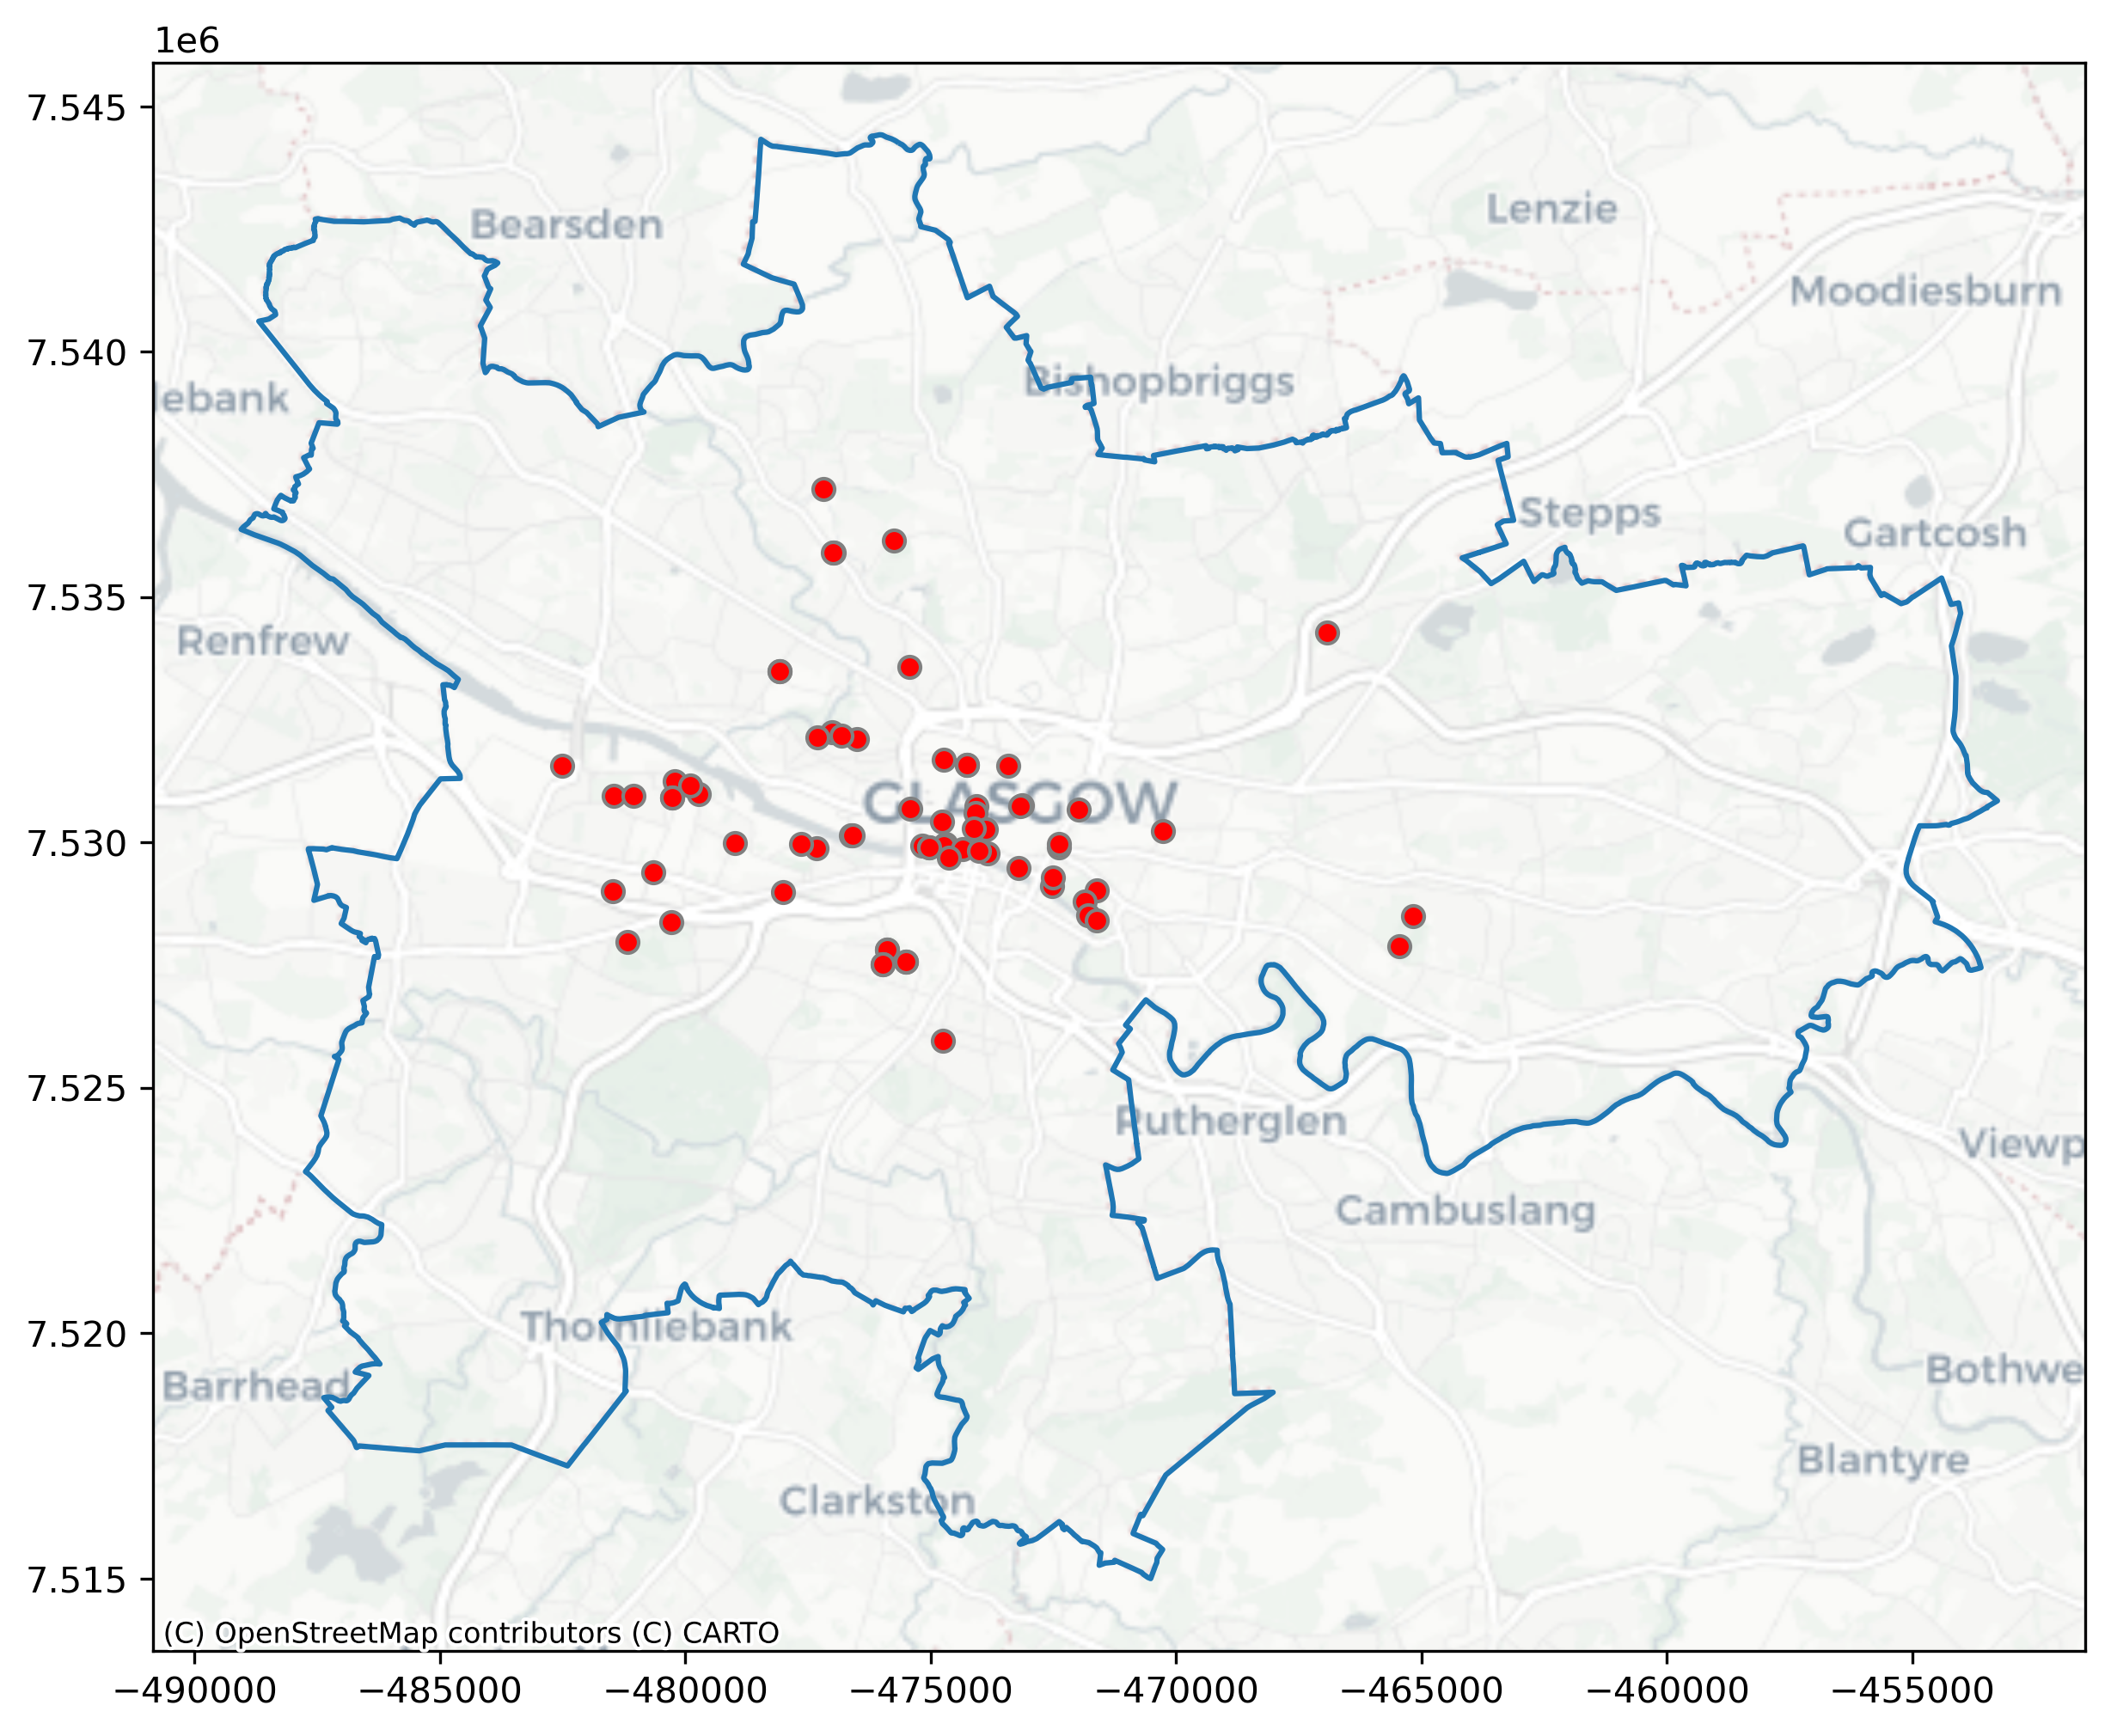

In [13]:
fig, ax = plt.subplots(figsize=(12,8), dpi=300) 
#Plot the data
camera_join.plot(color = 'red',edgecolor='grey',ax=ax,legend=True)
borough_gla.boundary.plot(ax=ax)
#Add basemap
ctx.add_basemap(ax, crs="EPSG:3857", source=ctx.providers.CartoDB.Positron)

Interactive map

In [14]:
m = borough_gla.explore(tiles='cartodbpositron', tooltip=['Name'], width=750, height=500)
m = camera_join.explore(color="Red", tooltip=['id','label','latitude','longitude'], m=m)
m

### 2. CCTV Object Detection Results

We can get the URL through the API Documents: https://glasgow-cctv.ubdc.ac.uk/api/docs

#### 2.1 Select camera & time period, query the data and create the dataframe

In [42]:
def get_results_for_camera(camera_id, start_date, end_date):
    
    url = f'https://glasgow-cctv.ubdc.ac.uk/api/yolo/records/?date_after={start_date}&date_before={end_date}&camera_id={camera_id}&page_size=1000'
    data = get_data(url)
    pages = int(data['count']/1000)+1
    
    results_list = []
    for i in range(pages):
        new_url = url + f'&page={i+1}'   
        results = get_data(new_url)['results']
        results_df = dict_to_dataframe(results)
        results_list.append(results_df)
        
    results_dfs = pd.concat(results_list, ignore_index=True, sort=False)
    
    results_dfs['timestamp'] =pd.to_datetime(results_dfs.timestamp)
    results_dfs['totalCount'] = results_dfs.apply(
        lambda row: row.cars + row.buses + row.pedestrians + row.lorries + row.cyclists + row.motorcycles + 
        row.vans + row.taxis, axis=1)
    results_dfs = results_dfs.sort_values(by=['timestamp']).reset_index(drop=True)
    
    return results_dfs

In [43]:
results_df = get_results_for_camera('427','20240101','20240401')
results_df

,id,camera_details,camera_pk,camera_ref,timestamp,camera_ok,model_name,cars,pedestrians,cyclists,motorcycles,buses,lorries,vans,taxis,totalCount
0,1375892,https://glasgow-cctv.ubdc.ac.uk/api/general/ca...,427,a13p2,2024-01-01 00:00:38+00:00,True,yolo,1,1,0,0,0,0,0,0,2
1,1375893,https://glasgow-cctv.ubdc.ac.uk/api/general/ca...,427,a13p2,2024-01-01 00:30:39+00:00,True,yolo,2,0,0,0,0,0,0,0,2
2,1375894,https://glasgow-cctv.ubdc.ac.uk/api/general/ca...,427,a13p2,2024-01-01 01:00:39+00:00,True,yolo,4,5,0,0,0,0,0,0,9
3,1375895,https://glasgow-cctv.ubdc.ac.uk/api/general/ca...,427,a13p2,2024-01-01 01:30:39+00:00,True,yolo,3,8,0,0,0,0,0,0,11
4,1375896,https://glasgow-cctv.ubdc.ac.uk/api/general/ca...,427,a13p2,2024-01-01 02:00:39+00:00,True,yolo,2,2,0,0,0,0,1,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4410,1707406,https://glasgow-cctv.ubdc.ac.uk/api/general/ca...,427,a13p2,2024-04-01 21:30:35+00:00,True,yolo,0,0,0,0,0,0,0,0,0
4411,1707452,https://glasgow-cctv.ubdc.ac.uk/api/general/ca...,427,a13p2,2024-04-01 22:00:35+00:00,True,yolo,1,0,0,0,0,0,0,0,1
4412,1707408,https://glasgow-cctv.ubdc.ac.uk/api/general/ca...,427,a13p2,2024-04-01 22:30:36+00:00,True,yolo,0,0,0,0,0,0,0,0,0
4413,1711006,https://glasgow-cctv.ubdc.ac.uk/api/general/ca...,427,a13p2,2024-04-01 23:00:35+00:00,True,yolo,0,0,0,0,0,0,0,0,0


#### 2.2 Make time series plot

<Axes: xlabel='timestamp'>

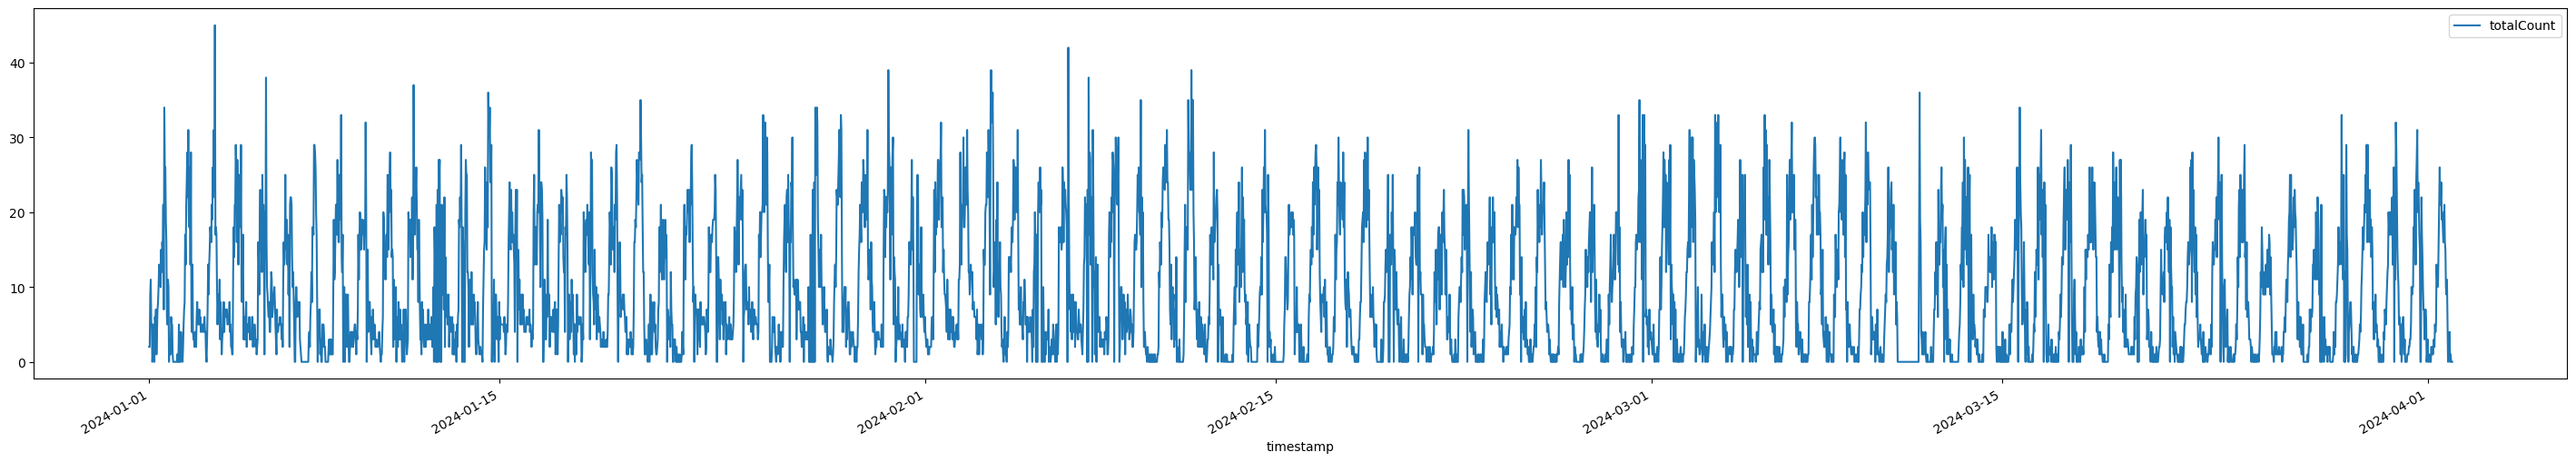

In [53]:
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.figsize"] = [36, 6]
results_df.plot(x='timestamp', y='totalCount')

### The data seem to have a periodicity aspect. During day the day, more 'objects' were counted. The opposite, is happening during the night.

This effect is called **periodicity**, and can be seen in many datasets that observe a variable over time through multiple periods.

In the recent years, timeseries analysis libraries have been developed for Python. One of the many functions provided by these libraries is their ability to **decompose (=decomposing break down into its elements. In the case of a timeserie, the core elements are: trend, periodicity, and noise.)** These elements, can be used then for further data insights.

Using these libraries, and a well defined, dataset, it's very easy to perform these functions, which can give us some insights regarding the nature of the element that we are observing.

The `statsmodels` library, is a Python library, that has a primary focus to provide, statistical models for data analysis.
Among its other submodules that provides, it has a clean timeSeries analysis API, suitable for our needs.

> https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html

```bash
# install statsmodel
$ pip install statsmodel
```

C:\Users\Amanda\AppData\Local\Temp\ipykernel_7000\2685568112.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['timestamp'] = pd.DatetimeIndex(df2.timestamp)


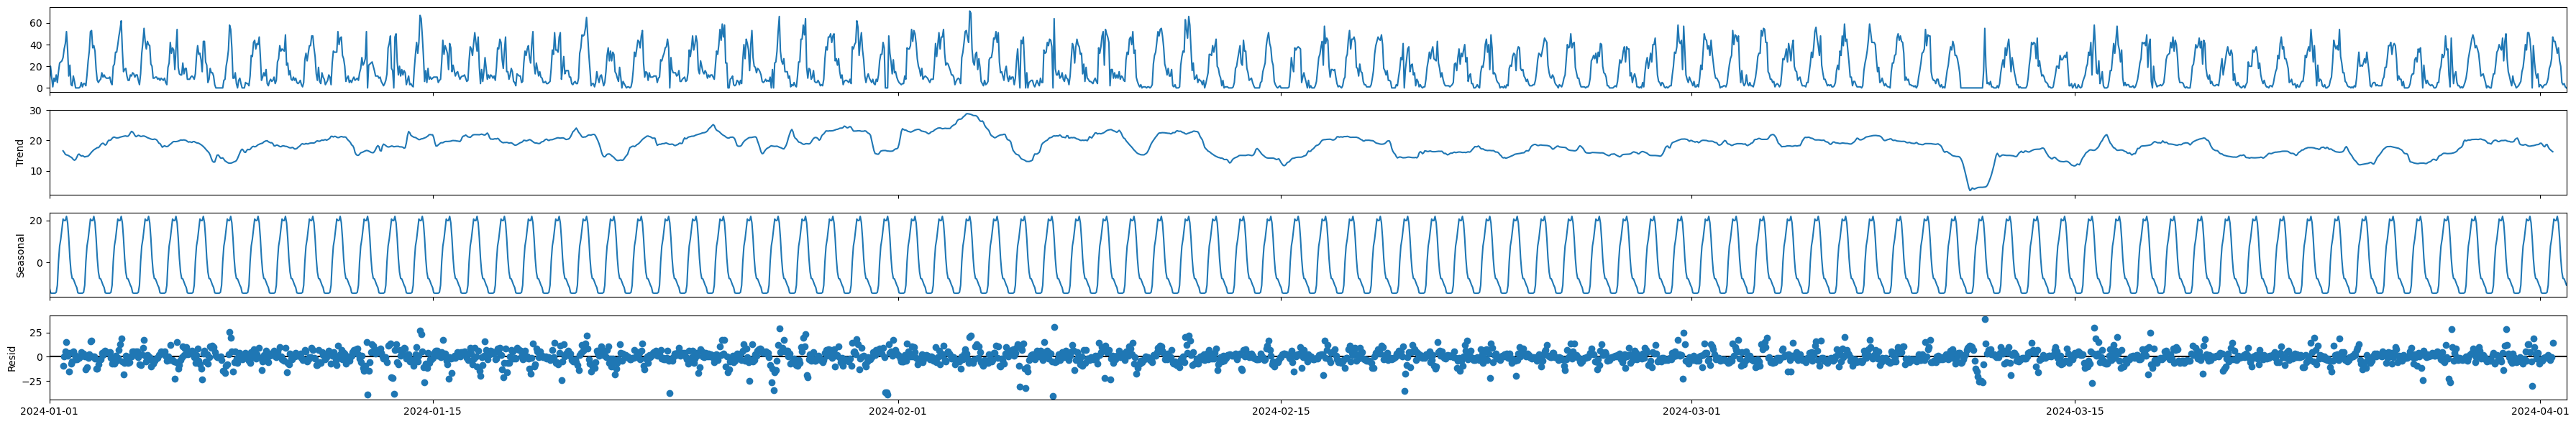

In [50]:
import statsmodels.api as sm

df2 = results_df[['timestamp', 'totalCount']]
df2['timestamp'] = pd.DatetimeIndex(df2.timestamp)
df2.set_index('timestamp', drop=True, inplace=True)

#  resample by, hour
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.resample.html
df3 = df2.resample('H').sum()

# decompose the timeseries to its elements using a naive model:
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html
decomposition = sm.tsa.seasonal_decompose(df3, model='additive')

# and plot.
fig = decomposition.plot()

#### Timeseries of the observed values are f(t) = Trend(t) + Periodicity(t) + Error(t) 

The rule of thumb to see if a model is performing adequate, is to examine the errors' chart: They should be as close to zero as possible.